In [1]:
import os

import gym
import gvgai
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import torchvision.transforms as T
import torch.nn.functional as F


from tqdm.notebook import tqdm

from matplotlib import pyplot as plt

from agent.NNagent import NNagent
from torch.autograd import Variable

In [2]:
class Value(nn.Module):
    def __init__(self, depth):
        super(Value, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=depth, out_channels=8, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3)
        self.fc = nn.Linear((32 * 3) + 4, 1)

    def forward(self, x, compass):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = x.view(len(x), 32 * 3)
        x = torch.cat([x, compass], dim=1)
        x = F.relu(self.fc(x))
        return x

In [3]:
from generator.env_gen_wrapper import GridGame
# from generator.levels.base import _initialize
# from generator.levels.base import Generator

In [28]:
env = GridGame(game='dzelda', 
                      play_length=1000, 
                      path='./levels',
                      lvl_name='2.txt',
                      mechanics=['+', 'g'], # monsters, key, door, wall
                      images=False,
                  )

In [29]:
print(str(env.generator))

wwwwwwwwwwwww
w...........w
w...........w
w.+.........w
w.....A.....w
w...........w
w..2........w
w.g.........w
wwwwwwwwwwwww



In [30]:
i = '2a'

_dir = f'./results/RL/map{i}'
tdir = f'./results/RL/map{i}/tmp'

os.mkdir(_dir)
os.mkdir(tdir)

path = os.path.join(_dir, 'lvl.txt')
with open(path, 'w+') as fname:
    fname.write(str(env.generator))

In [31]:
NGAMES = 500

In [ ]:
GAMMA = 0.99

total_rewards = []
total_estimate_rewards = []

for baseline in ['none', 'estimate']:
    policy = NNagent(GG=None, 
                     parent=torch.load('./results/RL/map2/baseline_best_model_policy.pt'),
                     actions=6, depth=13)
    optimizer = optim.Adam(policy.nn.parameters(), lr=.005)
    eps = np.finfo(np.float32).eps.item()
    
    V = Value(13)
    V.double()

    v_loss = nn.MSELoss()
    v_optimizer = optim.SGD(V.parameters(), lr=0.01)
    
    name = 'baseline' if baseline == 'estimate' else 'simple'
    
    best = -np.inf
    
    for i in tqdm(range(NGAMES)):
        state = env.reset()

        rewards = []
        states = [state]
        compass_info = []
        log_probs = []

        terminal = False
                
        while not terminal:
            # Action selection
            probs = policy.rl_get_action(state)
            compass_info.append(policy.compass_info)
            c = Categorical(probs)
            action = c.sample()
            log_probs.append(c.log_prob(action))

            # Carry out the action
            state, reward, terminal, _ = env.step(action.item())

            if not terminal:
                states.append(state)

            rewards.append(reward)

        if baseline == 'estimate':
            total_estimate_rewards.append(sum(rewards))
        else:
            total_rewards.append(sum(rewards))
            
        if sum(rewards) >= best:
            #checkpoint the network
            torch.save(policy.nn, os.path.join(_dir, f'{name}_best_model_policy.pt'))
            
        # Calculate the returns
        R = 0
        returns = []
        for r in reversed(rewards):
            R = r + GAMMA * R
            returns.insert(0, R)
        returns = torch.tensor(returns)

        values = V(torch.DoubleTensor(states), 
                   torch.DoubleTensor(np.vstack(compass_info)))

        if baseline == 'estimate':
            returns = returns - values.data.squeeze()

        # Calculate the loss
        policy_loss = [-log_prob * R for log_prob, R in zip(log_probs, returns)]

        # Backprop for the NN
        optimizer.zero_grad()
        policy_loss = torch.stack(policy_loss, dim=0).sum()
        policy_loss.backward()
        optimizer.step()

        # Backprop for the value estimator
        v_optimizer.zero_grad()
        estimate_loss = v_loss(values.squeeze(), returns.double())
        estimate_loss.backward()
        v_optimizer.step()
        
        # put check here to break if complete?
        
        if i % 100 == 0:
            torch.save(V, os.path.join(tdir, f'{name}_{i}_model_value.pt'))
            torch.save(policy.nn, os.path.join(tdir, f'{name}_{i}_model_policy.pt'))
    
    
    torch.save(V, os.path.join(_dir, f'{name}_{i}_model_value.pt'))
    torch.save(policy.nn, os.path.join(_dir, f'{name}_{i}_model_policy.pt'))

/home/aadharna/miniconda3/envs/thesis/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/aadharna/miniconda3/envs/thesis/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/aadharna/miniconda3/envs/thesis/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type MaxPool2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/aadharna/miniconda3/envs/thesis/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for co

In [ ]:
N=1
plt.figure(figsize=(15,10))
plt.plot(np.convolve(total_rewards, np.ones((N,))/N, mode='valid'), label='No Baseline')
plt.plot(np.convolve(total_estimate_rewards, np.ones((N,))/N, mode='valid'), label='Baseline')
plt.legend()
plt.savefig(os.path.join(_dir, 'reward_plot.jpg'))
plt.show()

----  
# Visualizations and tests

In [4]:
from IPython import display

In [5]:
def show_state(env, step=0, name="", info="", image=None):
    """Fn to visualize the agent playing the game in a notebook
    """
    plt.figure(10)
    plt.clf()
    if image is not None:
        im = image
    else:
        im = env.render(mode="rgb_array")[0]
    plt.imshow(im)
    plt.title("{} | Step: {} {}".format(name, step, info))
    plt.axis('off')
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [6]:
import imageio

In [7]:
e2 = NNagent(GridGame(game='dzelda', 
                      play_length=1000, 
                      path='./levels',
                      lvl_name='2.txt',
                      mechanics=['+', 'g'], # monsters, key, door, wall
                      images=True,),
             parent=torch.load('./results/RL/map2/simple_best_model_policy.pt'))

In [25]:
e2.nn = torch.load('./results/RL/map2/baseline_best_model_policy.pt')

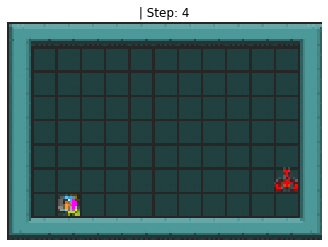

2.0

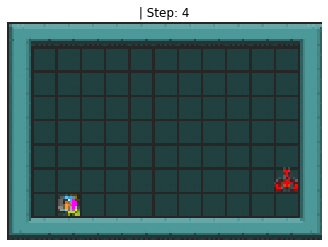

In [26]:
e2.fitness(fn=show_state, rl=True)

In [22]:
len(e2.images)

3040

In [23]:
imageio.mimsave('./results/RL/map2/long_zelda.gif', e2.images)

In [15]:
8*12

96

In [ ]:
# lvl = _initialize(env.lvl_path)
# g = Generator(tile_world=lvl,
#                            shape=lvl.shape,
#                            path=env.dir_path,
#                            mechanics=env.mechanics,
#                            generation=13,
#                            locations={})

In [ ]:
# for i in range(15):
#     m, s = g.mutate(1)
#     g = Generator(tile_world=None,
#                    shape=s,
#                    path=env.dir_path,
#                    mechanics=env.mechanics,
#                    generation=g.generation + 1,
#                    locations=m)


In [ ]:
# print(str(g))